Alexander S. Lundervold, October 18th, 2020

See also Geron's notebook: https://github.com/ageron/handson-ml2/blob/master/07_ensemble_learning_and_random_forests.ipynb

# Introduction

In the previous notebook `DAT158-Part2-5-Ensembling-RandomForests-and-Boosting.ipynb` we learned about random forests. 

Let's try it out on a couple of (slightly complicated) data sets. In addition to familiarizing ourselves with random forests, our goal in this notebook is to get used to working with data.

> **Note:** We won't do much data preparation or feature engineering. We'll also not investigate the data sets very thoroughly. Feel free to add more details to the stories told below (following the steps in Assignment 1, for example). 

# Setup

In [1]:
# To automatically reload modules defined in external files.
%reload_ext autoreload
%autoreload 2

# To display plots directly in the notebook:
%matplotlib inline

In [2]:
from pathlib import Path # Very convenient when working with paths in Python (https://docs.python.org/3.6/library/pathlib.html)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import sklearn

import seaborn as sns # For nicer plots

In [3]:
# To make the notebook reproducible
seed = 42
np.random.seed(seed)

## Downloading data

Before getting to the random forest, let's have a quick look at typical ways for downloading data. 

When working with standard benchmark data sets it's typically best to download from one of the several large data repositories, e.g. [OpenML](https://openml.org), [Kaggle Datasets](https://www.kaggle.com/datasets), [UCI ML Repository](https://archive.ics.uci.edu/ml/index.php), the [PMLB](https://github.com/EpistasisLab/penn-ml-benchmarks) or curated lists like [Dataset list](https://www.datasetlist.com). These are widely used and there are great tools for browsing and downloading data through Python. 

Another common way to get data is downloading from an URL. The library `urllib` is super-handy for this.

In [4]:
import urllib

In [5]:
import urllib.request

Downloading from databases is of course also relevant. See https://www.dataquest.io/blog/python-pandas-databases/ for some pointers.

> You should always try to download the data directly from your Jupyter Notebook! It helps a lot with reproducibility, and makes it easier to understand your work (for yourself and others)

# Random forests for classification

## Download data and have a quick look

We'll use a data set from OpenML:

In [6]:
from sklearn.datasets import fetch_openml

In [7]:
dating = fetch_openml(name='SpeedDating')

> **Note:** This data set is also available from Kaggle https://www.kaggle.com/annavictoria/speed-dating-experiment. And in fact it's simpler to download it from there (using the Kaggle API). However, we want to be ready for a variety of possible data formats and sources that are out there. You should try to repeat what we do below by downloading the data from Kaggle using the Kaggle API.

This returns a `Bunch`:

In [8]:
type(dating)

sklearn.utils.Bunch

containing the entire data set including descriptions, accessible by keys:

In [9]:
dating.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Here's the description:

In [10]:
print(dating['DESCR'])

**Author**: Ray Fisman and Sheena Iyengar  
**Source**: [Columbia Business School](http://www.stat.columbia.edu/~gelman/arm/examples/speed.dating/) - 2004  
**Please cite**: None  

This data was gathered from participants in experimental speed dating events from 2002-2004. During the events, the attendees would have a four-minute "first date" with every other participant of the opposite sex. At the end of their four minutes, participants were asked if they would like to see their date again. They were also asked to rate their date on six attributes: Attractiveness, Sincerity, Intelligence, Fun, Ambition, and Shared Interests. The dataset also includes questionnaire data gathered from participants at different points in the process. These fields include: demographics, dating habits, self-perception across key attributes, beliefs on what others find valuable in a mate, and lifestyle information. 

### Attribute Information
```
 * gender: Gender of self  
 * age: Age of self  
 * age_o: 

The actual data is stored under the key `data`. It is a Numpy array with 8378 instances each with 120 features:

In [11]:
dating['data'].shape

(8378, 120)

We prefer working with Pandas DataFrames, so let's create one:

In [12]:
X = pd.DataFrame(data=dating['data'], columns=dating['feature_names'])
y = dating.target

In [13]:
len(X), len(y)

(8378, 8378)

In [14]:
X.head()

,has_null,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,...,expected_num_interested_in_me,expected_num_matches,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met
0,0.0,1.0,0.0,21.0,27.0,6.0,0.0,0.0,0.0,0.0,...,2.0,4.0,0.0,0.0,0.0,7.0,6.0,0.0,0.0,0.0
1,0.0,1.0,0.0,21.0,22.0,1.0,1.0,0.0,0.0,0.0,...,2.0,4.0,0.0,0.0,0.0,7.0,5.0,0.0,0.0,1.0
2,1.0,1.0,0.0,21.0,22.0,1.0,1.0,0.0,1.0,1.0,...,2.0,4.0,0.0,0.0,0.0,7.0,NaN,0.0,1.0,1.0
3,0.0,1.0,0.0,21.0,23.0,2.0,2.0,0.0,0.0,0.0,...,2.0,4.0,0.0,0.0,0.0,7.0,6.0,0.0,0.0,0.0
4,0.0,1.0,0.0,21.0,24.0,3.0,2.0,0.0,2.0,0.0,...,2.0,4.0,0.0,0.0,0.0,6.0,6.0,0.0,0.0,0.0


In [15]:
X.head(15).T.head(20) # The first 15 instances and the first 20 features

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
has_null,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
wave,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0
gender,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
age,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.00,21.0,21.0,24.0,24.0,24.0,24.0,24.0
age_o,27.0,22.0,22.0,23.0,24.0,25.0,30.0,27.00,28.0,24.0,27.0,22.0,22.0,23.0,24.0
d_age,6.0,1.0,1.0,2.0,3.0,4.0,9.0,6.00,7.0,3.0,3.0,2.0,2.0,1.0,0.0
d_d_age,0.0,1.0,1.0,2.0,2.0,0.0,3.0,0.00,3.0,2.0,2.0,2.0,2.0,1.0,1.0
race,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,1.0,1.0,1.0,1.0,1.0
race_o,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,1.0,0.0,2.0
samerace,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,1.0,1.0,0.0,1.0,0.0


## Data exploration and preparation

### Dealing with missing values

There are many missing values in this data set, and we have to deal with them:

Total missing:

In [16]:
X.isnull().sum().sum()

18372

Missing by feature:

In [17]:
pd.set_option("display.max_rows", None) # To print all rows below

In [18]:
X.isnull().sum()

has_null                              0
wave                                  0
gender                                0
age                                  95
age_o                               104
d_age                                 0
d_d_age                               0
race                                 63
race_o                               73
samerace                              0
importance_same_race                 79
importance_same_religion             79
d_importance_same_race                0
d_importance_same_religion            0
field                                63
pref_o_attractive                    89
pref_o_sincere                       89
pref_o_intelligence                  89
pref_o_funny                         98
pref_o_ambitious                    107
pref_o_shared_interests             129
d_pref_o_attractive                   0
d_pref_o_sincere                      0
d_pref_o_intelligence                 0
d_pref_o_funny                        0


Sort according to number of missing:

In [19]:
X.isnull().sum().sort_values(ascending=False)

expected_num_interested_in_me      6578
expected_num_matches               1173
shared_interests_o                 1076
shared_interests_partner           1067
ambitous_o                          722
ambition_partner                    712
met                                 375
funny_o                             360
funny_partner                       350
guess_prob_liked                    309
intelligence_o                      306
intelligence_partner                296
sinsere_o                           287
sincere_partner                     277
like                                240
attractive_o                        212
attractive_partner                  202
interests_correlate                 158
pref_o_shared_interests             129
shared_interests_important          121
pref_o_ambitious                    107
intelligence                        105
sincere                             105
attractive                          105
ambition                            105


Let's not think much about it and just drop the column `expected_num_interested_in_me` which has a *lot* of missing values, and put in the most common value elsewhere:

In [20]:
X.drop('expected_num_interested_in_me', axis=1, inplace=True)

Impute the rest of the values (as you did in Assignment 1):

In [21]:
from sklearn.impute import SimpleImputer

In [22]:
imputer = SimpleImputer(strategy='most_frequent')

In [23]:
X_transformed = imputer.fit_transform(X)

We get an array

In [24]:
X_transformed

array([[ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  1.],
       [ 1.,  1.,  0., ...,  0.,  1.,  1.],
       ...,
       [ 1., 21.,  1., ...,  0.,  0.,  0.],
       [ 1., 21.,  1., ...,  1.,  0.,  0.],
       [ 1., 21.,  1., ...,  1.,  0.,  0.]])

...which we again turn into a data frame:

In [25]:
X = pd.DataFrame(X_transformed, columns=X.columns)

In [26]:
X.head()

,has_null,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,...,expected_happy_with_sd_people,expected_num_matches,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met
0,0.0,1.0,0.0,21.0,27.0,6.0,0.0,0.0,0.0,0.0,...,3.0,4.0,0.0,0.0,0.0,7.0,6.0,0.0,0.0,0.0
1,0.0,1.0,0.0,21.0,22.0,1.0,1.0,0.0,0.0,0.0,...,3.0,4.0,0.0,0.0,0.0,7.0,5.0,0.0,0.0,1.0
2,1.0,1.0,0.0,21.0,22.0,1.0,1.0,0.0,1.0,1.0,...,3.0,4.0,0.0,0.0,0.0,7.0,5.0,0.0,1.0,1.0
3,0.0,1.0,0.0,21.0,23.0,2.0,2.0,0.0,0.0,0.0,...,3.0,4.0,0.0,0.0,0.0,7.0,6.0,0.0,0.0,0.0
4,0.0,1.0,0.0,21.0,24.0,3.0,2.0,0.0,2.0,0.0,...,3.0,4.0,0.0,0.0,0.0,6.0,6.0,0.0,0.0,0.0


No more missing values:

In [27]:
X.isnull().sum().sum()

0

We notice that all the values seem to be integers, not floats. Let's guess that that's the case, and convert all the non-missing values to integers:

In [28]:
X = X.astype('int32')

In [29]:
X.head()

,has_null,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,...,expected_happy_with_sd_people,expected_num_matches,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met
0,0,1,0,21,27,6,0,0,0,0,...,3,4,0,0,0,7,6,0,0,0
1,0,1,0,21,22,1,1,0,0,0,...,3,4,0,0,0,7,5,0,0,1
2,1,1,0,21,22,1,1,0,1,1,...,3,4,0,0,0,7,5,0,1,1
3,0,1,0,21,23,2,2,0,0,0,...,3,4,0,0,0,7,6,0,0,0
4,0,1,0,21,24,3,2,0,2,0,...,3,4,0,0,0,6,6,0,0,0


In [30]:
X.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8378 entries, 0 to 8377
Data columns (total 119 columns):
 #   Column                           Dtype
---  ------                           -----
 0   has_null                         int32
 1   wave                             int32
 2   gender                           int32
 3   age                              int32
 4   age_o                            int32
 5   d_age                            int32
 6   d_d_age                          int32
 7   race                             int32
 8   race_o                           int32
 9   samerace                         int32
 10  importance_same_race             int32
 11  importance_same_religion         int32
 12  d_importance_same_race           int32
 13  d_importance_same_religion       int32
 14  field                            int32
 15  pref_o_attractive                int32
 16  pref_o_sincere                   int32
 17  pref_o_intelligence              int32
 18  pref_o_

> We notice that many variables that are really categorical, even binary like `gender`. It's not necessary to store them as int32. It would be convenient to convert all categorical variables (there are 64 of them), and keep the numeric attributes (there are 59) as integers. Feel free to do this!

### Exploring the data

Let's explore the data a bit (but just a bit! Feel free to explore further on your own, perhaps by following the steps you took in Assignment 1).

We need to split off a test set before we start digging into the data:

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

Let's look at the age and gender distribution:

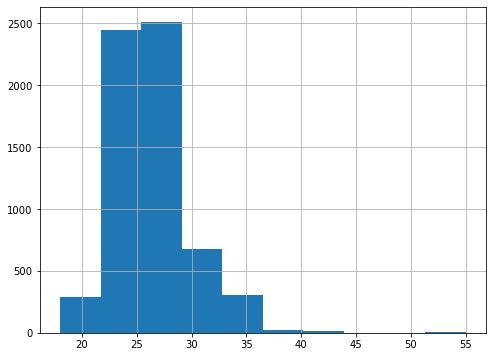

In [33]:
X_train['age'].hist(figsize=(8,6))
plt.show()

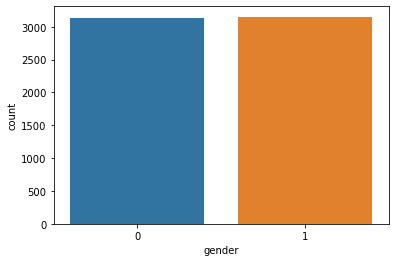

In [34]:
sns.countplot(X_train['gender'])
plt.show()

We notice that the speed dating event was quite balanced among the genders.

How successful were the participants? Let's count the number of people that found a match. This is stored in y:

In [35]:
y[:5]

array(['0', '0', '1', '1', '1'], dtype=object)

...as strings, it seems. It's more convenient to store it as integers: 

In [36]:
y = [int(i) for i in y]

Percentage of matches:

In [37]:
np.sum(y)/len(y) * 100

16.47171162568632

Only 16% of participants found a match after the speed dating experiment..

> Feel free to explore the data set further, perhaps by following your approach in Assignment 1 / Chapter 2. What can you say about correlations? Are there any features you should add? 

Let's move on to our random forest:

## Random forest classifier

In [38]:
from sklearn.ensemble import RandomForestClassifier

In [39]:
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=30, random_state=42, n_jobs=-1)

In [40]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=30, n_jobs=-1, random_state=42)

In [41]:
rf_clf.score(X_test, y_test)

0.8572792362768497

We can predict who will get a second date with 86% accuracy!

> And now for what everyone's waiting for: what are the most important features for getting a second date?

Let's first look at `feature_importances`. Then, remebering that feature importances are not very reliable, permutation importance like in previous notebooks.

**Feature importances**

In [42]:
importances = rf_clf.feature_importances_

In [43]:
indices = np.argsort(importances)[::-1]

Here are the top 10:

In [44]:
for f in range(10): 
    print(f'{X.columns[indices[f]]}: {np.round(importances[indices[f]],2)}')

like: 0.04
attractive_o: 0.04
shared_interests_o: 0.03
attractive_partner: 0.03
funny_partner: 0.03
funny_o: 0.03
guess_prob_liked: 0.02
shared_interests_partner: 0.02
field: 0.02
pref_o_attractive: 0.01


**Permutation importance**

In [45]:
import eli5
from eli5.sklearn import PermutationImportance

D:\Anaconda3\envs\dat158\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
D:\Anaconda3\envs\dat158\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [46]:
perm = PermutationImportance(rf_clf, random_state=42).fit(X_test, y_test)

In [47]:
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0074 ± 0.0025,like
0.0053 ± 0.0033,guess_prob_liked
0.0052 ± 0.0019,attractive_o
0.0045 ± 0.0032,shared_interests_o
0.0040 ± 0.0029,attractive_partner
0.0025 ± 0.0007,d_like
0.0019 ± 0.0014,shared_interests_partner
0.0016 ± 0.0032,d_attractive_o
0.0016 ± 0.0023,movies
0.0016 ± 0.0018,pref_o_funny


How does the importance of the various features differ between men and women? To find out, we can train one model on men and another on women.

In [48]:
X_train_men, y_train_men = X_train.loc[X_train['gender'] == 1], y_train[X_train['gender'] == 1]

X_train_women, y_train_women = X_train.loc[X_train['gender'] == 0], y_train[X_train['gender'] == 0]

In [49]:
rf_clf_men = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_clf_men.fit(X_train_men, y_train_men)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [50]:
rf_clf_women = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_clf_women.fit(X_train_women, y_train_women)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [51]:
def print_feature_importances(clf, num):
    """
    Prints the num most important features of the trained classifier clf
    """
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    for f in range(num): 
        print(f'{X.columns[indices[f]]}: {np.round(importances[indices[f]],3)}')

In [52]:
print_feature_importances(rf_clf_men, 10)

attractive_o: 0.037
shared_interests_o: 0.035
attractive_partner: 0.033
funny_o: 0.03
like: 0.027
guess_prob_liked: 0.027
shared_interests_partner: 0.019
funny_partner: 0.019
pref_o_shared_interests: 0.016
pref_o_attractive: 0.015


In [53]:
print_feature_importances(rf_clf_women, 10)

like: 0.036
funny_partner: 0.034
attractive_partner: 0.033
attractive_o: 0.03
shared_interests_partner: 0.029
shared_interests_o: 0.025
funny_o: 0.025
guess_prob_liked: 0.023
pref_o_attractive: 0.016
pref_o_shared_interests: 0.015


Not how this differs from the permutation importance (which in general is more believable): 

In [54]:
def print_permutation_importances(clf):
    """
    Prints the num most important features of the trained classifier clf
    """
    perm = PermutationImportance(clf, random_state=42).fit(X_test, y_test)
    display(eli5.show_weights(perm, feature_names = X_test.columns.tolist()))

In [55]:
print_permutation_importances(rf_clf_men)

Weight,Feature
0.0090 ± 0.0020,attractive_o
0.0075 ± 0.0024,like
0.0074 ± 0.0027,guess_prob_liked
0.0070 ± 0.0059,attractive_partner
0.0053 ± 0.0034,shared_interests_o
0.0046 ± 0.0018,d_attractive_o
0.0042 ± 0.0032,shared_interests_partner
0.0037 ± 0.0025,funny_o
0.0027 ± 0.0022,d_shared_interests_partner
0.0027 ± 0.0031,d_funny_o


In [56]:
print_permutation_importances(rf_clf_women)

Weight,Feature
0.0077 ± 0.0020,attractive_o
0.0049 ± 0.0044,like
0.0046 ± 0.0068,attractive_partner
0.0038 ± 0.0029,shared_interests_o
0.0030 ± 0.0035,expected_num_matches
0.0026 ± 0.0047,funny_partner
0.0023 ± 0.0048,shared_interests_partner
0.0021 ± 0.0026,d_attractive_o
0.0021 ± 0.0013,guess_prob_liked
0.0021 ± 0.0046,funny_o


> **Your turn!** It could be interesting to look at partial dependence plots as well. Feel free to try it out!

Notice that we overfit the training data:

In [57]:
rf_clf.score(X_train, y_train)

1.0

Looking at the parameters of the random forest above, and thinking back to decision trees, we can guess how we can regularize the model to reduce the overfitting. For example, we can reduce the minimum number of samples each leaf must contain, and/or the maximum number of leaf nodes:

In [58]:
rf_clf = RandomForestClassifier(n_estimators=100, min_samples_leaf=10, max_leaf_nodes=20, random_state=42)

In [59]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_leaf_nodes=20, min_samples_leaf=10, random_state=42)

In [60]:
rf_clf.score(X_test, y_test)

0.8482100238663485

In [61]:
rf_clf.score(X_train, y_train)

0.8540506127646029

## Wait a minute!

We are pretty happy with ourselves: we're able to predict matches with an accuracy of 85%, and we've found some fun results on gender differences in dating. 

<br>
<center><b><span style="font-size:300%">BUT!</span></b></center>

Only 16% of the participants are marked as matches. Therefore, if we predict everyone to be `match=0` we'll score about 84%... Making 85% not very impressive.. 

If only there were ways to evaluate classifiers more carefully than accuracy... :-) Luckily, we've studied classification very thoroughly in Module 1, and are equipped with many tools. 

In [62]:
from sklearn.metrics import confusion_matrix

In [63]:
y_pred = rf_clf.predict(X_test)

In [64]:
cm = confusion_matrix(y_test, y_pred)

In [65]:
import itertools

*Below code taken from Module 2 about classification*:

In [67]:
def plot_confusion_matrix(cm, classes, ax=None,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, labels=True):
    """
    This function prints and plots the confusion matrix.
    From 
    """
    
    if not ax: fig, ax = plt.subplots(figsize=(8,6))
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    tick_marks = np.arange(len(classes))
    plt.setp(ax, xticks=tick_marks, xticklabels=classes, 
             yticks=tick_marks, yticklabels=classes,
             title=title, xlabel="Predicted label", 
             ylabel="True label")
    #ax.set_xticks(tick_marks, classes, rotation=45)
    #plt.yticks(tick_marks, classes)

    if labels:
        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            ax.text(j, i, format(int(cm[i, j]), fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    return ax

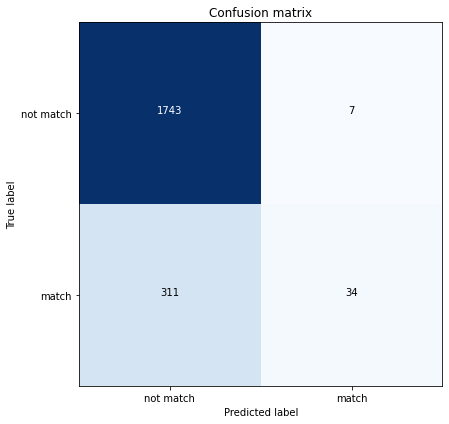

In [68]:
_ = plot_confusion_matrix(cm, ['not match', 'match'])

We see that our model is **almost rubbish**! Invalidating all the fun observations we did above. Beware of such mistakes!

> **Your turn!** Use the above confusion matrix to calculate the **precision** and **recall** of the classifer by hand. See Module 1 of the course if you've forgotten how. Then do the same using scikit-learn.

> **Your turn!** Try to improve the model by finding better hyperparameters and perhaps also better imputing strategies. You can also consider adding new features, and removing some that seem unimportant. Remember to do your model selection based on a validation data set.

# Another classification example

Let's have a look at how machine learning can be used on electronic health records data through a (small) example.

From data gathered from 100.000 patients, collected by Microsoft here https://microsoft.github.io/r-server-hospital-length-of-stay/index.html, we will try to predict the length of stay of patients admitted to the hospital. Such a system (if it was sufficiently robust and accurate) would be extremely valuable. For hospital resource management, i.e. managing personnel and planning for patient discharge at hospital departments. 

By investigating what features have the largest explanatory power for a trained machine learning model, such a system could also potentially uncover interesting connections between journal data and patient conditions. 

I've downloaded and prepared the data, stored in the data folder:

## Load and inspect the data

In [69]:
DATA = Path('./localdata/rfexamples_data/hospital')

The data set consists of three files:

In [70]:
LOS = pd.read_pickle(DATA/'hospital')
DICT = pd.read_excel(DATA/'Data_Dictionary.xlsx')
METADATA = pd.read_csv(DATA/'MetaData_Facilities.csv')

In [71]:
LOS.head()

,rcount,gender,facid,eid,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,...,neutrophils,sodium,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,secondarydiagnosisnonicd9,lengthofstay
0,0,0,1,1,False,False,False,False,False,False,...,14.20,140.361130,192.476913,12.0,1.390722,30.432417,96,6.5,4,3
1,5,0,0,2,False,False,False,False,False,False,...,4.10,136.731689,94.078506,8.0,0.943164,28.460516,61,6.5,1,7
2,1,0,1,3,False,False,False,False,False,False,...,8.90,133.058517,130.530518,12.0,1.065750,28.843811,64,6.5,2,3
3,0,0,0,4,False,False,False,False,False,False,...,9.40,138.994019,163.377029,12.0,0.906862,27.959007,76,6.5,1,1
4,0,0,4,5,False,False,False,True,False,True,...,9.05,138.634842,94.886658,11.5,1.242854,30.258926,67,5.6,2,4


In [72]:
LOS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 26 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   rcount                      100000 non-null  int32  
 1   gender                      100000 non-null  int32  
 2   facid                       100000 non-null  int32  
 3   eid                         100000 non-null  int32  
 4   dialysisrenalendstage       100000 non-null  bool   
 5   asthma                      100000 non-null  bool   
 6   irondef                     100000 non-null  bool   
 7   pneum                       100000 non-null  bool   
 8   substancedependence         100000 non-null  bool   
 9   psychologicaldisordermajor  100000 non-null  bool   
 10  depress                     100000 non-null  bool   
 11  psychother                  100000 non-null  bool   
 12  fibrosisandother            100000 non-null  bool   
 13  malnutrition   

In [73]:
DICT

,Index,Data fields,Type,Descriptions
0,NaN,LengthOfStay,NaN,NaN
1,1.0,eid,Integer,Unique Id of the hospital admission
2,2.0,vdate,String,Visit date
3,3.0,rcount,Integer,Number of readmissions within last 180 days
4,4.0,gender,String,Gender of the patient\nM or F
5,5.0,dialysisrenalendstage,String,Flag for renal disease during encounter
6,6.0,asthma,String,Flag for asthma during encounter
7,7.0,irondef,String,Flag for iron deficiency during encounter
8,8.0,pneum,String,Flag for pneumonia during encounter
9,9.0,substancedependence,String,Flag for substance dependence during encounter


In [74]:
METADATA

,Capacity,Id,Name
0,30,C,General Medicine 3 South
1,95,E,Behavioral 1 East
2,75,A,General Medicine 3 West
3,80,B,Pulmonary 2 West
4,100,D,Geriatrics 2 East


### Some simple observations

It seems that `LOS` is our main source of information. `DICT` provides useful information about the features in `LOS`, while `METADATA` contains information about the various hospital departments the data is collected from.

> **OBS**: I have changed the features in our version of `LOS` a bit compared to the [original](https://github.com/Microsoft/r-server-hospital-length-of-stay/raw/master/Data/LengthOfStay.csv). All stays longer than 8 days have been merged. All the `rcount` marked as "5+" have been set to 5.

## Further exploration

What is the length of stay distribution?

In [75]:
LOS_value_count = LOS['lengthofstay'].value_counts()
LOS_value_count

1              17979
3              16068
4              14822
2              12825
5              12116
6              10362
7               7263
8               4652
more than 8     3913
Name: lengthofstay, dtype: int64

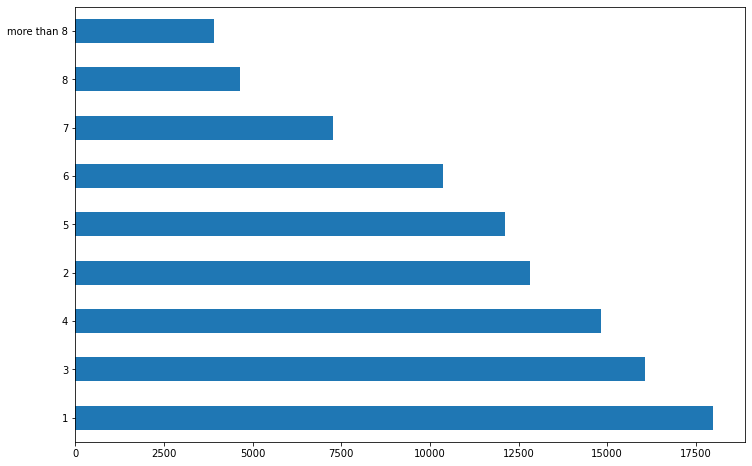

In [76]:
LOS_value_count.plot.barh(figsize=(12,8))
plt.show()

We note that the data set is pretty imbalanced. Most of the stays at the hospital are short.

How's the gender balance?

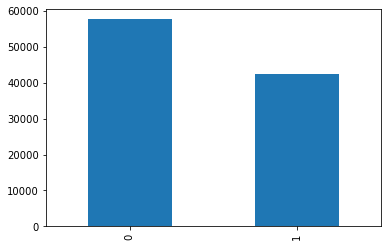

In [77]:
gender_counts = LOS['gender'].value_counts()
gender_counts.plot.bar()
plt.show()

A bit more men than women.

Is there a difference in how long they stay at the hospital?

In [78]:
# First we convert "more than 8" to the number 9, for plotting purposes:
LOS_tmp = LOS.copy()

D:\Anaconda3\envs\dat158\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


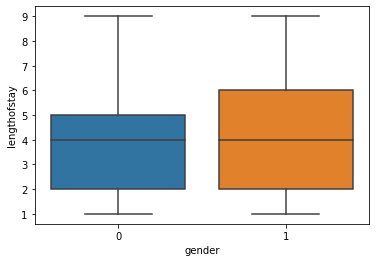

In [79]:
LOS_tmp['lengthofstay'].loc[LOS_tmp['lengthofstay'] == 'more than 8'] = 9 # Convert "more than 8" to 9

LOS_tmp['lengthofstay'] = LOS_tmp['lengthofstay'].astype(int) # Change to integers

# Box plot:
ax = sns.boxplot(x='gender', y='lengthofstay', data=LOS_tmp)

### Correlations

How do the numerical features correlate to length of stay?

In [80]:
DICT

,Index,Data fields,Type,Descriptions
0,NaN,LengthOfStay,NaN,NaN
1,1.0,eid,Integer,Unique Id of the hospital admission
2,2.0,vdate,String,Visit date
3,3.0,rcount,Integer,Number of readmissions within last 180 days
4,4.0,gender,String,Gender of the patient\nM or F
5,5.0,dialysisrenalendstage,String,Flag for renal disease during encounter
6,6.0,asthma,String,Flag for asthma during encounter
7,7.0,irondef,String,Flag for iron deficiency during encounter
8,8.0,pneum,String,Flag for pneumonia during encounter
9,9.0,substancedependence,String,Flag for substance dependence during encounter


In [81]:
correlation_matrix = LOS_tmp.corr()
correlation_matrix['lengthofstay'].sort_values(ascending=False)

lengthofstay                  1.000000
rcount                        0.752818
facid                         0.363066
psychologicaldisordermajor    0.289187
hemo                          0.213832
irondef                       0.192063
psychother                    0.185655
malnutrition                  0.169207
dialysisrenalendstage         0.162927
substancedependence           0.147174
bloodureanitro                0.141912
pneum                         0.132303
depress                       0.122732
asthma                        0.084388
gender                        0.068686
fibrosisandother              0.060492
pulse                         0.006616
secondarydiagnosisnonicd9     0.006339
eid                           0.001203
bmi                          -0.000181
glucose                      -0.002465
sodium                       -0.002510
creatinine                   -0.004156
neutrophils                  -0.011813
respiration                  -0.019343
hematocrit               

**Observations:**

* `rcount` is very correlated to length of stay. The number of hospital visits during the last 180 days says a lot about expected length of stay.
* `facid` is also quite correlated. That could be caused by varying capacity of the different departments, and the different patient population they serve.

Most patients haven't been to the hospital during the last 180 days, but some are frequent guests:

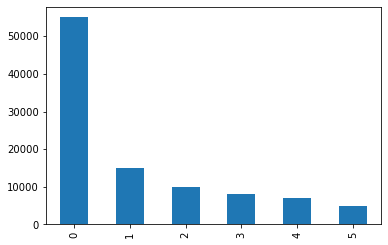

In [82]:
LOS['rcount'].value_counts().plot.bar()
plt.show()

Here's the capacity of the different departments:

In [83]:
METADATA

,Capacity,Id,Name
0,30,C,General Medicine 3 South
1,95,E,Behavioral 1 East
2,75,A,General Medicine 3 West
3,80,B,Pulmonary 2 West
4,100,D,Geriatrics 2 East


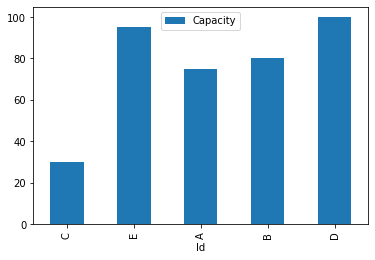

In [84]:
METADATA.plot(x='Id', y='Capacity', kind='bar')
plt.show()

## Let's try to make a predictive model

We treat this as a classification problem. I.e. 

> Is the expected length of stay 1, 2, 3, 4, 5, 6, 7, 8 or more than 8 days?

It's also possible to treat it like regression. Feel free to try!

In [85]:
X = LOS.drop('lengthofstay', axis=1)
y = LOS['lengthofstay']

### Separate a test set

To simulate the real situation where our model is used to predict length of stay as a new patient arrives, we set aside a test set to evaluate the model.

In [86]:
from sklearn.model_selection import train_test_split

As the data set is quite imbalanced we use a stratified split. This ensures that the length of stay distribution is the same in the training and test sets.

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

### Select a model

In [88]:
from sklearn.ensemble import RandomForestClassifier

In [89]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

We train the model:

In [90]:
rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

...and calculate the accuracy on the test data:

In [91]:
from sklearn.metrics import accuracy_score

In [92]:
y_pred = rf.predict(X_test)
accuracy_score(y_test, y_pred)

0.66676

The model is predicting the length of stay on the test data with an accuracy of about 67%.

### Evaluating the result

Is this a good result? What features are used by the model in making its predictions?

In [93]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [95]:
from utils import plot_confusion_matrix

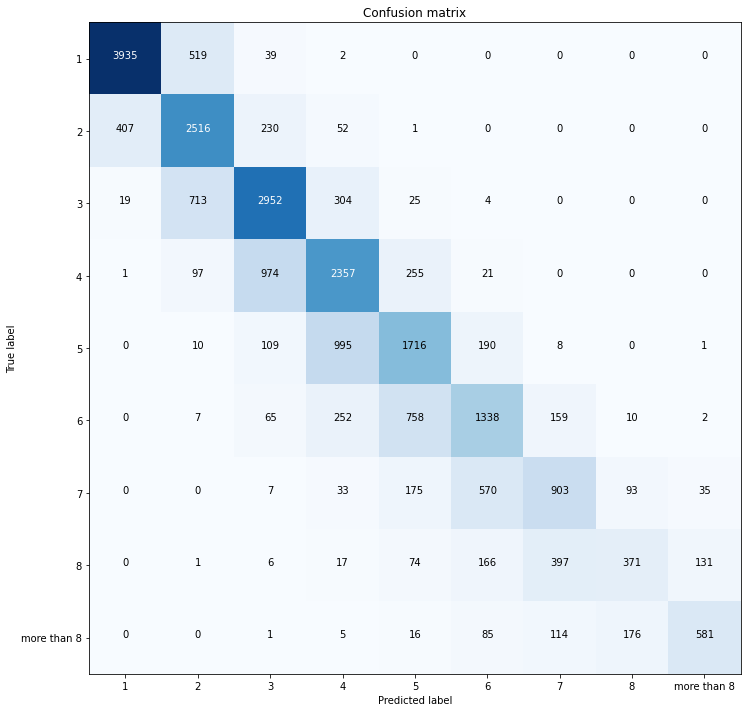

In [96]:
fig, ax = plt.subplots(figsize=(12,10))
_ = plot_confusion_matrix(cm, classes=np.unique(y_test), ax=ax)

### Feature importance

In [97]:
importances = rf.feature_importances_
# Find index of those with highest importance, sorted from largest to smallest:
indices = np.argsort(importances)[::-1]
for f in range(X.shape[1]): 
    print(f'{X.columns[indices[f]]}: {np.round(importances[indices[f]],2)}')

rcount: 0.22
bmi: 0.08
creatinine: 0.08
glucose: 0.08
sodium: 0.08
pulse: 0.07
hematocrit: 0.07
neutrophils: 0.06
eid: 0.05
facid: 0.04
respiration: 0.04
bloodureanitro: 0.04
secondarydiagnosisnonicd9: 0.03
psychologicaldisordermajor: 0.02
hemo: 0.01
gender: 0.01
irondef: 0.01
substancedependence: 0.01
dialysisrenalendstage: 0.01
depress: 0.01
asthma: 0.0
pneum: 0.0
malnutrition: 0.0
psychother: 0.0
fibrosisandother: 0.0


We notice that the model depends quite a bit on the `rcount` feature, as expected. 

What about (the more robust) permutation importance?

In [98]:
perm = PermutationImportance(rf, random_state=42).fit(X_test, y_test)

In [99]:
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.3913 ± 0.0037,rcount
0.1097 ± 0.0028,psychologicaldisordermajor
0.0772 ± 0.0041,facid
0.0728 ± 0.0038,hematocrit
0.0622 ± 0.0031,bmi
0.0592 ± 0.0036,creatinine
0.0564 ± 0.0033,sodium
0.0547 ± 0.0013,glucose
0.0524 ± 0.0028,pulse
0.0456 ± 0.0023,respiration


> **Your turn!** An hypothesis for why `psychologicaldisordermajor` is so important is that patients with this flag set to `True` are special. Perhaps they are often in the "Behavioral" department? Investigate this. Also investigate any other hypothesis you can think of. 

A natural question to ask is "If the number of visits increase, does the length of stay also increase?". Or the other way around? Or is there a more complicated connection between the two?

We can (partly) uncover this by using **partial dependence plots**, as before.  

### Partial dependence plots

In [100]:
from pdpbox import pdp

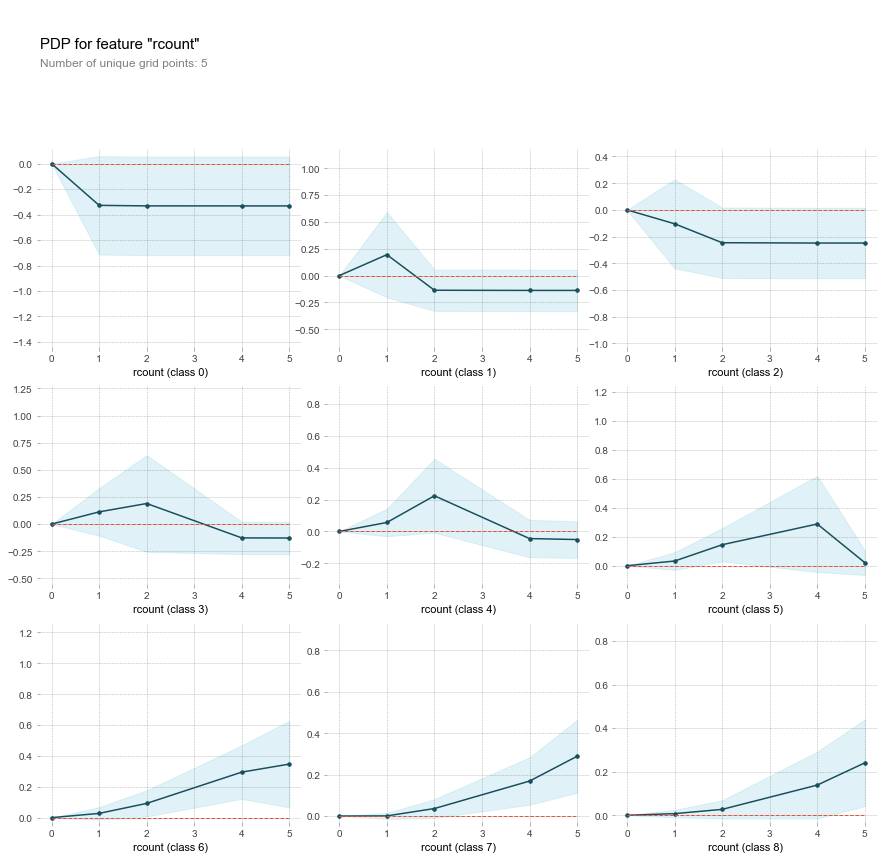

In [101]:
pdp_goals = pdp.pdp_isolate(model=rf, dataset=X_test, model_features=X_test.columns.tolist(), feature='rcount', n_jobs=-1)
pdp.pdp_plot(pdp_goals, 'rcount', ncols=3)
plt.show()

We see that for short stays the expected number of days in the hospital doesn't increase much. For stays of 6 days or more there is however such a connection. 

> **Your turn!** What diseases (of those recorded in our data set) characterizes pasients with high `rcount`?

## Feature engineering

Some features are more important than others for our model. Some describe the patients in a more *expedient* way than others. That is, they are of greater value for our predictive model.

> But these are not necessarily *the best* features!

One of the most important parts of ML (and often underappreciated) is **feature engineering**. 

Machine learning is, basically, about **function approximation**. You want to find a function that is as close as possible to the *true function* mapping from the set of features to correct label or value.  

> In general, the more *complicated* the true function is, the harder it is for the machine learning model. 

By describing the raw data with new, more suitable features it is possible to reduce the complexity of the true function. As an extreme example, if we had the date of entry and date of exit for each of our patients then the true function could be very simple: exit minus entry equals length of stay. 

There's a lot of room between doing nothing and actually put the label as a feature (which is of course not useful). That's what feature engineering is about.

The best way to do feature engineering is to influence how the data is collected. Then it's possible to add new features that one believes could be useful for modelling (for example, we could add the patient age in our example). 

If you cannot influence data collection one should rather think as follows: (i) bring in external features (f.ex. if we had the patients personal identification number we could access other data bases containing more information), or (ii) create new features by combine the ones we have. 

> Any machine learning project will involve some feature engineering! (Deep learning is kind of an exception as we saw in the introduction to the course). 

### Adding a new feature: number of problems per patient

Each patient is associated to a number of flags for different conditions:

```
 'dialysisrenalendstage',
 'asthma',
 'irondef',
 'pneum',
 'substancedependence',
 'psychologicaldisordermajor',
 'depress',
 'psychother',
 'fibrosisandother',
 'malnutrition',
 'hemo'
 ```

In [102]:
DICT

,Index,Data fields,Type,Descriptions
0,NaN,LengthOfStay,NaN,NaN
1,1.0,eid,Integer,Unique Id of the hospital admission
2,2.0,vdate,String,Visit date
3,3.0,rcount,Integer,Number of readmissions within last 180 days
4,4.0,gender,String,Gender of the patient\nM or F
5,5.0,dialysisrenalendstage,String,Flag for renal disease during encounter
6,6.0,asthma,String,Flag for asthma during encounter
7,7.0,irondef,String,Flag for iron deficiency during encounter
8,8.0,pneum,String,Flag for pneumonia during encounter
9,9.0,substancedependence,String,Flag for substance dependence during encounter


Let's make a feature that simply counts all the issues per patient. The idea is that the number of issues influences the length of stay, and if we add it as a feature we make it simpler for the model to pick up on this. 

In [103]:
issues = ['dialysisrenalendstage',
 'asthma',
 'irondef',
 'pneum',
 'substancedependence',
 'psychologicaldisordermajor',
 'depress',
 'psychother',
 'fibrosisandother',
 'malnutrition',
 'hemo']

In [104]:
LOS.insert(len(LOS.columns)- 1, 'numberofissues', LOS[issues].astype('int').sum(axis=1))

In [105]:
LOS.head()

,rcount,gender,facid,eid,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,...,sodium,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,secondarydiagnosisnonicd9,numberofissues,lengthofstay
0,0,0,1,1,False,False,False,False,False,False,...,140.361130,192.476913,12.0,1.390722,30.432417,96,6.5,4,0,3
1,5,0,0,2,False,False,False,False,False,False,...,136.731689,94.078506,8.0,0.943164,28.460516,61,6.5,1,0,7
2,1,0,1,3,False,False,False,False,False,False,...,133.058517,130.530518,12.0,1.065750,28.843811,64,6.5,2,0,3
3,0,0,0,4,False,False,False,False,False,False,...,138.994019,163.377029,12.0,0.906862,27.959007,76,6.5,1,0,1
4,0,0,4,5,False,False,False,True,False,True,...,138.634842,94.886658,11.5,1.242854,30.258926,67,5.6,2,2,4


In [106]:
LOS['numberofissues'].value_counts()

0    57341
1    23350
2    11536
3     4660
4     2018
5      773
6      261
7       46
8       12
9        3
Name: numberofissues, dtype: int64

### A new model with our new feature included

In [107]:
X = LOS.drop('lengthofstay', axis=1)
y = LOS['lengthofstay']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1) 

In [108]:
rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [109]:
y_pred = rf.predict(X_test)
accuracy_score(y_test, y_pred)

0.67816

We're now predicting the lenght of stay with an accuracy of about 68%. _Slightly_ better than before. 

Let's have a look at the permutation importance:

In [110]:
perm = PermutationImportance(rf, random_state=42).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist(), top=None)

Weight,Feature
0.4000 ± 0.0026,rcount
0.2792 ± 0.0051,numberofissues
0.0683 ± 0.0018,hematocrit
0.0596 ± 0.0028,bmi
0.0560 ± 0.0036,glucose
0.0553 ± 0.0018,creatinine
0.0547 ± 0.0030,sodium
0.0512 ± 0.0032,pulse
0.0437 ± 0.0023,respiration
0.0239 ± 0.0020,neutrophils


Our new feature turned out to be quite important!

## How to improve models?

Our accuracy of 68% isn't great. How would you go about improving it? In general, how do you improve a machine learning model's performance? Here are som standard ways:

1. Collect better data. Perhaps the problem was framed wrong during data collection? Is the data collected in a prudent way, fit for your purpose?
2. Get more data. Real data, synthesized data, or similar data.
3. Create new, better features. Also consider removing uninformative features (these can reduce performance by increasing data size requirements)
4. Preprocess the data better. Scaling, transformations, etc
5. Use a better adapted model. Most ML models can be tuned by selecting better hyperparameters. They can be made more or less complex, which is useful when trying to approximate the true function of a given complexity. "Everything should be made as simple as possible, but not simpler". 
6. Use a different class of model. Perhaps you've used a model that cannot become sufficiently complex (e.g. logistic regression on a complicated data set)? Or perhaps your model is too complex? 
7. Use multiple models together in an ensemble. For example using hard or soft voting. Or let each model be based on slightly different features than the others, making the models more independent of each other. You can also use a model to learn how the ensemble should best be combined, or sequentially train models trying to predict the errors of the previous models and then combine them to produce predictions. 

# Random forests for regression

Happiness! Can we predict how happy the population of a country is? 

We'll use data from the United Nations World Happiness Report: http://worldhappiness.report, conveniently organized on Kaggle: https://www.kaggle.com/unsdsn/world-happiness

In [112]:
import IPython

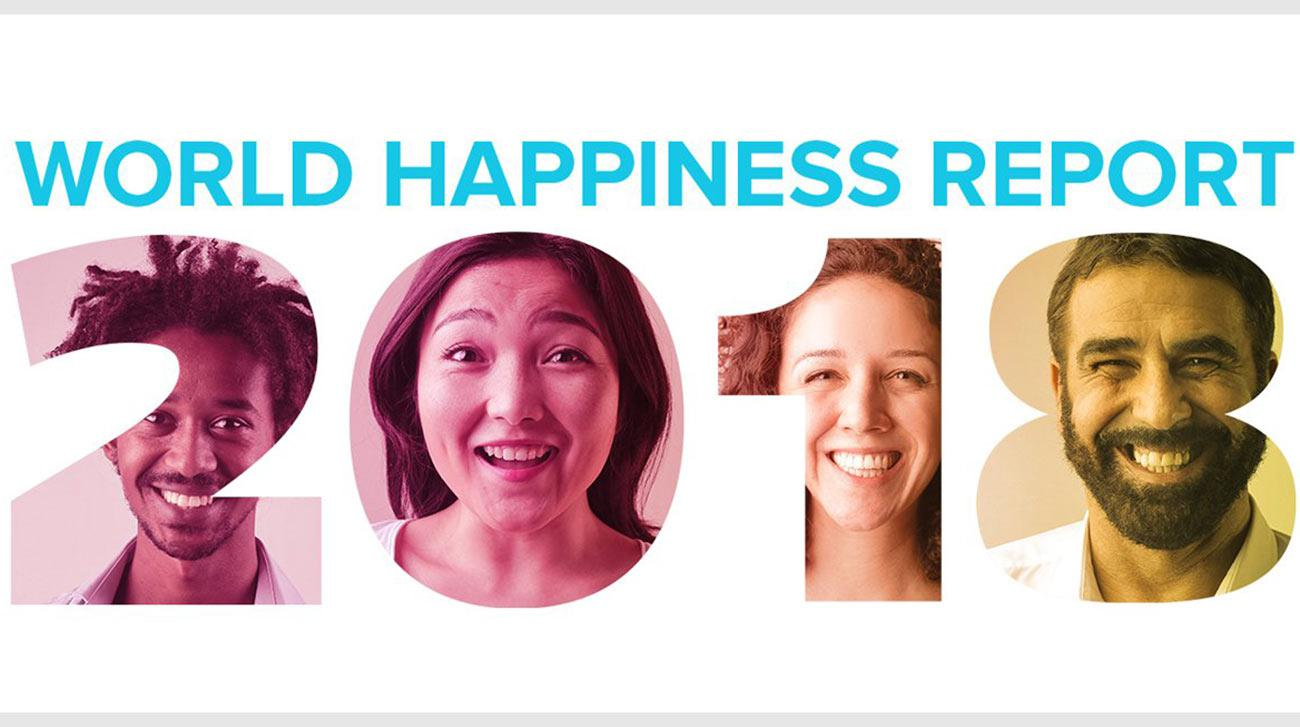

In [113]:
IPython.display.Image("assets/happines-web.jpg", width='50%')

## Get the data

First we need to decide where to store the data. Any time you work with paths in Python you should consider <a href="https://docs.python.org/3.6/library/pathlib.html">pathlib</a>. It's a super convenient, object-oriented way to work with paths in Python.

In [114]:
from pathlib import Path

In [115]:
NB_DIR = %pwd # Sets NB_DIR to the current directory
NB_DIR = Path(NB_DIR)
DATA = NB_DIR/'localdata/rfexamples_data/'

We'll run our Kaggle API command from within Python using the <a href="https://docs.python.org/3.6/library/subprocess.html">subprocess</a> module. Make sure you've installed the Kaggle API (https://github.com/Kaggle/kaggle-api) in your base environment (`pip install kaggle --upgrade`) and that you've created an API token on kaggle.com and placed in in the correct location. See https://github.com/Kaggle/kaggle-api for instructions.

In [ ]:
import subprocess
command = f'kaggle datasets download -d unsdsn/world-happiness -p {DATA}'
subprocess.call(command, shell=True)

We see that we've downloaded a zip file:

In [ ]:
%ls $DATA

Let's unzip:

In [ ]:
import zipfile
with zipfile.ZipFile(DATA/'world-happiness.zip',"r") as zip_ref:
    zip_ref.extractall(DATA)

In [116]:
%ls $DATA

 Volume in drive D has no label.
 Volume Serial Number is 3564-0073

 Directory of D:\Dropbox_alex\Dropbox\Jobb\HIB\Kurs\DAT158\DAT158ML-2020\notebooks\localdata\rfexamples_data

21.10.2020  16.54    <DIR>          .
21.10.2020  16.54    <DIR>          ..
04.08.2020  08.48            16ÿ557 2015.csv
04.08.2020  08.48            17ÿ132 2016.csv
04.08.2020  08.48            29ÿ536 2017.csv
04.08.2020  08.48           366ÿ859 cal_housing_py3.pkz
04.08.2020  08.48            12ÿ857 Data_Dictionary.xlsx
04.08.2020  08.48            25ÿ822 diabetes.csv
21.10.2020  16.54    <DIR>          hospital
04.08.2020  08.48            23ÿ347 indian_liver_patient.csv
04.08.2020  08.48        12ÿ418ÿ298 LengthOfStay.csv
04.08.2020  08.48           129ÿ634 LengthOfStay_Prod.csv
04.08.2020  08.48               145 MetaData_Facilities.csv
21.10.2020  16.54    <DIR>          sensor
04.08.2020  08.48            29ÿ326 world-happiness.zip
              11 File(s)     13ÿ069ÿ513 bytes
               4 Dir(s)  

There are three new .csv files: 2015.csv, 2016.csv, 2017.csv. Let's use the one from 2016 for now:

In [117]:
happiness = pd.read_csv(DATA/'2016.csv')

## Inspect the data

In [118]:
happiness.head()

,Country,Region,Happiness Rank,Happiness Score,Lower Confidence Interval,Upper Confidence Interval,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,Denmark,Western Europe,1,7.526,7.460,7.592,1.44178,1.16374,0.79504,0.57941,0.44453,0.36171,2.73939
1,Switzerland,Western Europe,2,7.509,7.428,7.590,1.52733,1.14524,0.86303,0.58557,0.41203,0.28083,2.69463
2,Iceland,Western Europe,3,7.501,7.333,7.669,1.42666,1.18326,0.86733,0.56624,0.14975,0.47678,2.83137
3,Norway,Western Europe,4,7.498,7.421,7.575,1.57744,1.12690,0.79579,0.59609,0.35776,0.37895,2.66465
4,Finland,Western Europe,5,7.413,7.351,7.475,1.40598,1.13464,0.81091,0.57104,0.41004,0.25492,2.82596


We'll try to predict the Happiness Score from the other features, dropping the Happiness Rank and also the name of the country (it's likely not very relevant for predicting happiness, at least when we know the country's region).

The features *Lower Confidence Interval* and *Upper Confidence Interval* are also not useful for our predictions.

In [119]:
happiness = happiness.drop(['Lower Confidence Interval', 'Upper Confidence Interval'], axis=1)

In [120]:
X = happiness.drop([
    'Happiness Rank',
    'Country',
    'Happiness Score'],
    axis=1
)
y = happiness['Happiness Score']

In [121]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Region                         157 non-null    object 
 1   Economy (GDP per Capita)       157 non-null    float64
 2   Family                         157 non-null    float64
 3   Health (Life Expectancy)       157 non-null    float64
 4   Freedom                        157 non-null    float64
 5   Trust (Government Corruption)  157 non-null    float64
 6   Generosity                     157 non-null    float64
 7   Dystopia Residual              157 non-null    float64
dtypes: float64(7), object(1)
memory usage: 9.9+ KB


In [122]:
X.describe()

,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
count,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000
mean,0.953880,0.793621,0.557619,0.370994,0.137624,0.242635,2.325807
std,0.412595,0.266706,0.229349,0.145507,0.111038,0.133756,0.542220
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.817890
25%,0.670240,0.641840,0.382910,0.257480,0.061260,0.154570,2.031710
50%,1.027800,0.841420,0.596590,0.397470,0.105470,0.222450,2.290740
75%,1.279640,1.021520,0.729930,0.484530,0.175540,0.311850,2.664650
max,1.824270,1.183260,0.952770,0.608480,0.505210,0.819710,3.837720


We see that there are no missing values. All the values except Region are floats. 

As we remember from Assignment 1, it's a good idea to get a feel for the data by visualizing the features using histograms, correlations and boxplots:

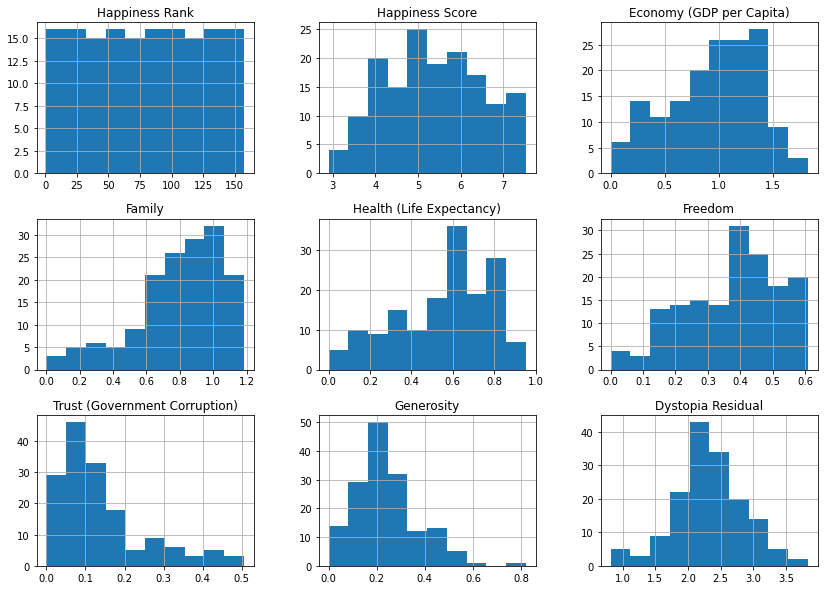

In [123]:
happiness.hist(figsize=(14,10))
plt.show()

`Region` is a categorical feature

In [124]:
happiness['Region'].value_counts()

Sub-Saharan Africa                 38
Central and Eastern Europe         29
Latin America and Caribbean        24
Western Europe                     21
Middle East and Northern Africa    19
Southeastern Asia                   9
Southern Asia                       7
Eastern Asia                        6
North America                       2
Australia and New Zealand           2
Name: Region, dtype: int64

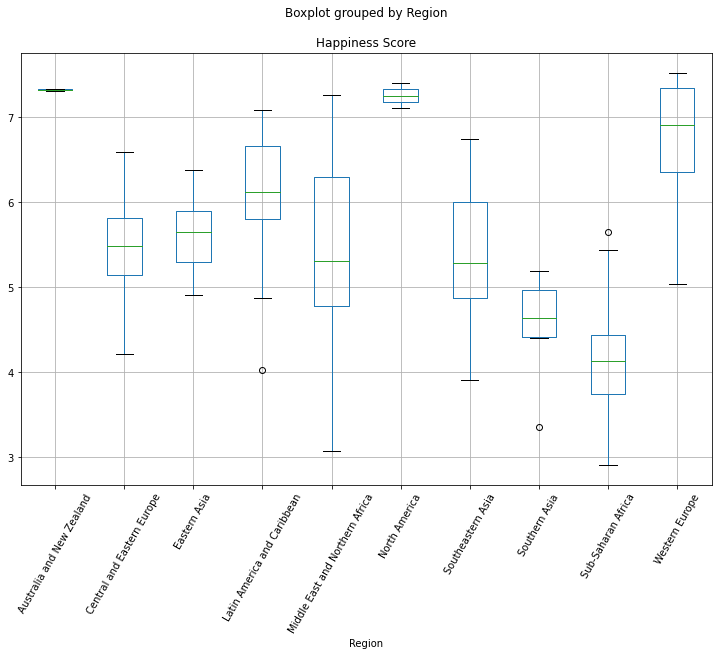

In [125]:
happiness.boxplot('Happiness Score', 'Region', rot=60, figsize=(12,8))
plt.show()

Using Seaborn we can get a nicer looking plot:

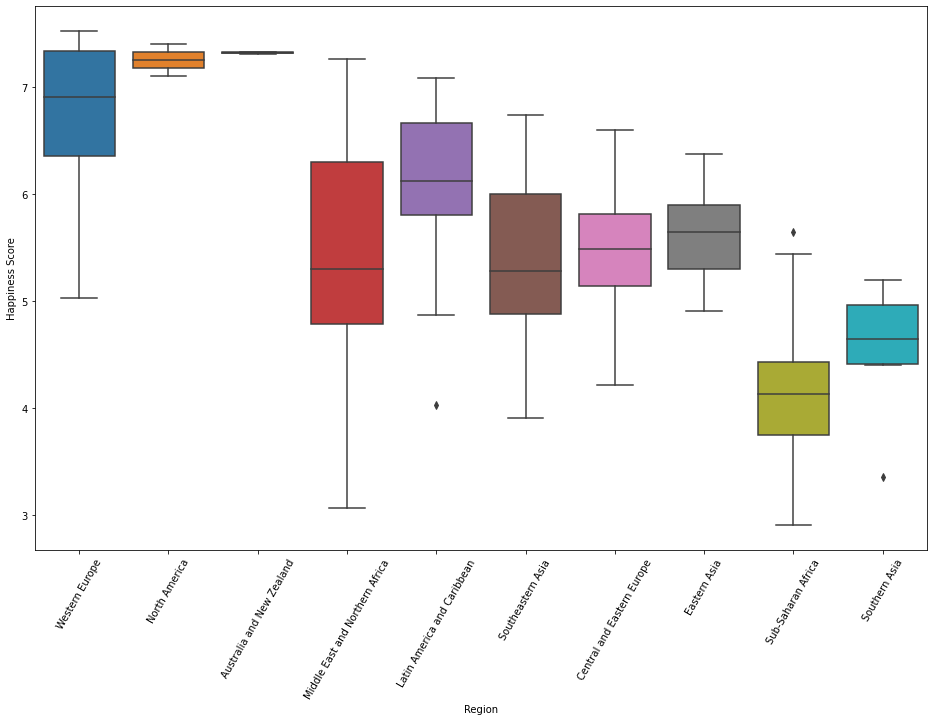

In [126]:
plt.figure(figsize=(16,10))
ax = sns.boxplot(x='Region', y='Happiness Score', data=happiness)
ax.set_xticklabels(ax.get_xticklabels(),rotation=60)
plt.show()

We already notive many interesting things about the happiness distribution! For example, the region with the largest spread in happiness is *Middle East and Northern Africa*. *North America* has little spread, but it only consists of two countries.. 

Looking at the correlations among different features (as in Assignment 1) is also very useful:

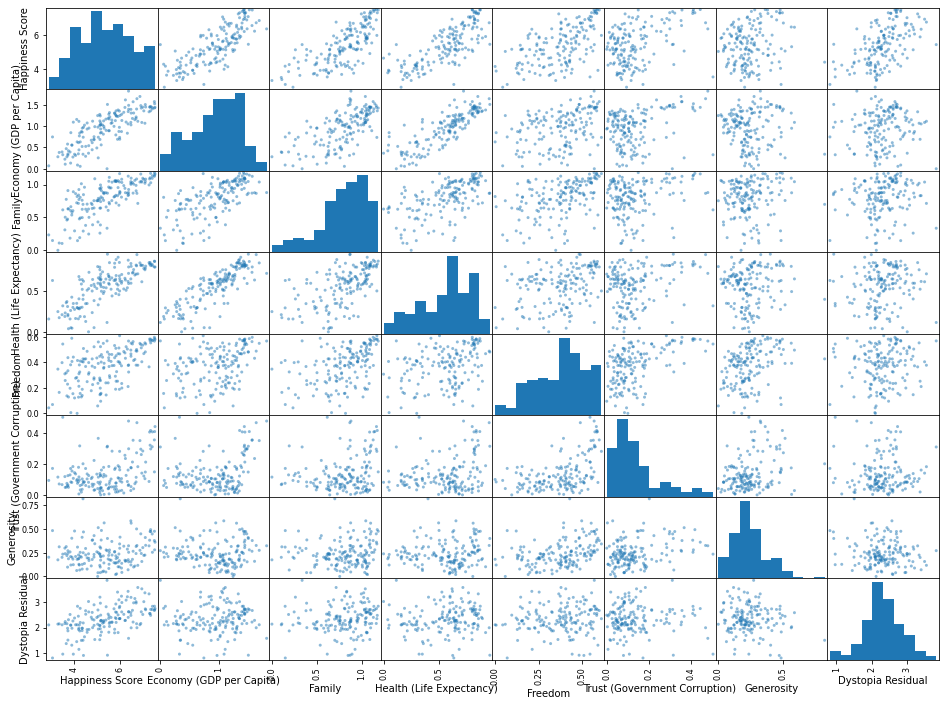

In [127]:
from pandas.plotting import scatter_matrix
scatter_matrix(happiness.drop(['Happiness Rank', 'Country'], axis=1), figsize=(16,12))
plt.show()

We notice from the above plots that there are some correlations between the Happiness Score (top row) and other features.

We can also look at these correlations directly:

In [128]:
corr_matrix = happiness.drop(['Happiness Rank', 'Country'], axis=1).corr()
corr_matrix

,Happiness Score,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
Happiness Score,1.000000,0.790322,0.739252,0.765384,0.566827,0.402032,0.156848,0.543738
Economy (GDP per Capita),0.790322,1.000000,0.669540,0.837067,0.362283,0.294185,-0.025531,0.068624
Family,0.739252,0.669540,1.000000,0.588377,0.450208,0.213561,0.089629,0.119672
Health (Life Expectancy),0.765384,0.837067,0.588377,1.000000,0.341199,0.249583,0.075987,0.100857
Freedom,0.566827,0.362283,0.450208,0.341199,1.000000,0.502054,0.361751,0.091631
Trust (Government Corruption),0.402032,0.294185,0.213561,0.249583,0.502054,1.000000,0.305930,-0.002909
Generosity,0.156848,-0.025531,0.089629,0.075987,0.361751,0.305930,1.000000,-0.133001
Dystopia Residual,0.543738,0.068624,0.119672,0.100857,0.091631,-0.002909,-0.133001,1.000000


It's easier to see what's going on in a plot:

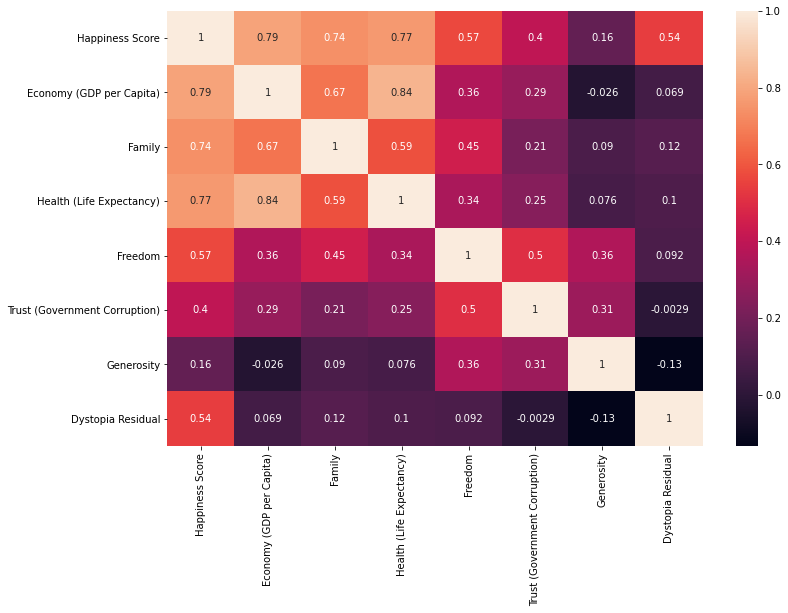

In [129]:
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix,annot=True)
plt.show()

## Prepare the data for ML

In [130]:
X_train, X_test, y_train, y_test = train_test_split(happiness.drop('Happiness Score', axis=1), happiness['Happiness Score'], 
                                                    stratify=happiness['Region'], test_size=.1, random_state=1)

In [131]:
X_train.head()

,Country,Region,Happiness Rank,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
121,Kenya,Sub-Saharan Africa,122,0.52267,0.76240,0.30147,0.40576,0.06686,0.41328,1.88326
56,Poland,Central and Eastern Europe,57,1.24585,1.04685,0.69058,0.45190,0.05500,0.14443,2.20035
89,Morocco,Middle East and Northern Africa,90,0.84058,0.38595,0.59471,0.25646,0.08404,0.04053,2.94891
41,Bahrain,Middle East and Northern Africa,42,1.44024,0.94397,0.65696,0.47375,0.25772,0.17147,2.27405
8,Australia,Australia and New Zealand,9,1.44443,1.10476,0.85120,0.56837,0.32331,0.47407,2.54650


These are the countries we'll try to predict the happiness for:

In [132]:
X_test['Country'], len(X_test)

(60                 Belarus
 70                 Romania
 101                   Laos
 75                 Somalia
 126    Congo (Brazzaville)
 138            Ivory Coast
 58                 Bolivia
 111                   Iraq
 11                 Austria
 30                Colombia
 140                 Angola
 18                 Ireland
 109             Bangladesh
 52                   Japan
 62                Slovenia
 79                  Jordan
 Name: Country, dtype: object,
 16)

We drop `Country` and `Happiness Rank` as before:

In [133]:
X_train = X_train.drop(['Country', 'Happiness Rank'], axis=1)
X_test = X_test.drop(['Country', 'Happiness Rank'], axis=1)

As we know from Assignment 1, we should take care of the categorical variable `Region` by encoding it.

In [134]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

X_train['Region'] = ordinal_encoder.fit_transform(X_train['Region'].values.reshape(-1, 1))
X_test['Region'] = ordinal_encoder.transform(X_test['Region'].values.reshape(-1, 1))

In [135]:
X_train.head()

,Region,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
121,8.0,0.52267,0.76240,0.30147,0.40576,0.06686,0.41328,1.88326
56,1.0,1.24585,1.04685,0.69058,0.45190,0.05500,0.14443,2.20035
89,4.0,0.84058,0.38595,0.59471,0.25646,0.08404,0.04053,2.94891
41,4.0,1.44024,0.94397,0.65696,0.47375,0.25772,0.17147,2.27405
8,0.0,1.44443,1.10476,0.85120,0.56837,0.32331,0.47407,2.54650


In [136]:
X_test.head()

,Region,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
60,1.0,1.13062,1.04993,0.63104,0.29091,0.17457,0.13942,2.38582
70,1.0,1.16970,0.72803,0.67602,0.36712,0.00679,0.12889,2.45184
101,6.0,0.68042,0.54970,0.38291,0.52168,0.22423,0.43079,2.08637
75,8.0,0.00000,0.33613,0.11466,0.56778,0.31180,0.27225,3.83772
126,8.0,0.77109,0.47799,0.28212,0.37938,0.09753,0.12077,2.10681


## Random forest regressor

Now we're ready for a random forest!

In [137]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [138]:
from sklearn.metrics import mean_absolute_error
y_pred = rf_reg.predict(X_test)
mean_absolute_error(y_test, y_pred)

0.2599037499999999

Our model is off by 0.26 happiness points on average for our 16 test countries. 

We can plot this in a scatter plot:

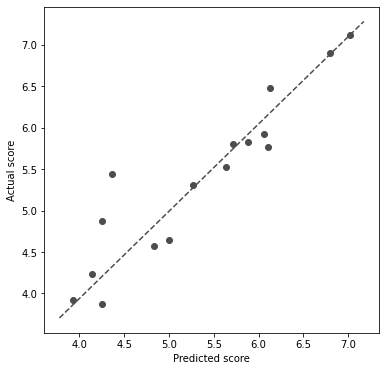

In [139]:
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(y_pred, y_test, c=".3")
diag_line, = ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
plt.xlabel("Predicted score")
plt.ylabel("Actual score")
plt.show()

The interesting question now is: "What features are most predictive for happiness in our model?"

In [140]:
perm = PermutationImportance(rf_reg, random_state=42).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist(), top=None)

Weight,Feature
0.3118 ± 0.1441,Dystopia Residual
0.2518 ± 0.1126,Economy (GDP per Capita)
0.1802 ± 0.2077,Health (Life Expectancy)
0.0884 ± 0.0547,Family
0.0454 ± 0.0350,Freedom
0.0132 ± 0.0153,Trust (Government Corruption)
0.0021 ± 0.0131,Region
-0.0000 ± 0.0055,Generosity


In [141]:
importances = rf_reg.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(len(X.columns)): 
    print(f'{X.columns[indices[f]]}: {np.round(importances[indices[f]],3)}')

Economy (GDP per Capita): 0.364
Health (Life Expectancy): 0.314
Dystopia Residual: 0.148
Family: 0.077
Freedom: 0.062
Trust (Government Corruption): 0.017
Generosity: 0.012
Region: 0.008


> **Your turn!** Try to improve the result by tuning hyperparameters or using a different model

> Feel free to play around with the data set further. Looking at the trends from 2015 to 2017 would be interesting (perhaps even 2018 if you download that data from the UN). You could also try to combine the data with other sources, e.g. data from Gapminder, to get a more detailed description of the world.

# Your turn

> **Your turn!** I've downloaded another classification data set and placed it in `./localdata/rfexamples_data/indian_liver_patient.csv`. It contains data from 416 liver patients and 167 non-liver patients, collected at Andhra Pradesh, India. It's described further here: https://archive.ics.uci.edu/ml/datasets/ILPD+(Indian+Liver+Patient+Dataset. From 10 features the task is to predict whether an instance belongs to a patient or a non-patient. Load the data using Pandas, explore it, and try to predict the patient status. 

> **Your turn!** Here's a simple data set for predicting life expectancy in a country based on a few features: 'https://assets.datacamp.com/production/course_1939/datasets/gm_2008_region.csv'. It comes from Gapminder and is prepared by DataCamp. Download the data using f.ex. `pd.read_csv(url)`, explore the data and create a model for life expectancy prediction.

# Extra: Another classification problem

Let's try to predict what a human is doing based sensor data collected from the wearers mobile phone. The data set is from UCI Machine Learning, and is also available via Kaggle https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones. 

From 30 users doing everyday things, data was collected by a smartphone. Our task is to predict what task was performed directly from the sensor measurements. 

In [142]:
import IPython
IPython.display.IFrame(width="560", height="315", src="https://www.youtube.com/embed/XOEN9W05_4A")

Here's a description of the data set, pasted from Kaggle:

The Human Activity Recognition database was built from the recordings of 30 study participants performing activities of daily living (ADL) while carrying a waist-mounted smartphone with embedded inertial sensors. The objective is to classify activities into one of the six activities performed.

> **Description of experiment**<br>
The experiments have been carried out with a group of 30 volunteers within an age bracket of 19-48 years. Each person performed six activities (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING) wearing a smartphone (Samsung Galaxy S II) on the waist. Using its embedded accelerometer and gyroscope, we captured 3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz. The experiments have been video-recorded to label the data manually. The obtained dataset has been randomly partitioned into two sets, where **70% of the volunteers was selected for generating the training data and 30% the test data**.

> The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window). The sensor acceleration signal, which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body acceleration and gravity. The gravitational force is assumed to have only low frequency components, therefore a filter with 0.3 Hz cutoff frequency was used. From each window, a vector of features was obtained by calculating variables from the time and frequency domain.

> **Attribute information**<br>
> For each record in the dataset the following is provided:

> * Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration.
* Triaxial Angular velocity from the gyroscope.
* A 561-feature vector with time and frequency domain variables.
* Its activity label.
* An identifier of the subject who carried out the experiment.

## Load the data

As the data seems to be missing from Kaggle currently, we'll use a local copy. To download using the API one would run the below code:

In [ ]:
#command = f'kaggle datasets download -d uciml/human-activity-recognition-with-smartphones -p {DATA}'
#subprocess.call(command, shell=True)

In [143]:
DATA = Path('./localdata/rfexamples_data/sensor')

In [144]:
train = pd.read_csv(DATA/'train.csv')
test = pd.read_csv(DATA/'test.csv')

These are two data frames consisting of a long series of sensor measurements, marked by corresponding activities.

In [145]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 31.6+ MB


In [146]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2947 entries, 0 to 2946
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 12.7+ MB


In [147]:
pd.set_option('display.max_columns', 600)

In [148]:
train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",tGravityAcc-mean()-X,tGravityAcc-mean()-Y,tGravityAcc-mean()-Z,tGravityAcc-std()-X,tGravityAcc-std()-Y,tGravityAcc-std()-Z,tGravityAcc-mad()-X,tGravityAcc-mad()-Y,tGravityAcc-mad()-Z,tGravityAcc-max()-X,tGravityAcc-max()-Y,tGravityAcc-max()-Z,tGravityAcc-min()-X,tGravityAcc-min()-Y,tGravityAcc-min()-Z,tGravityAcc-sma(),tGravityAcc-energy()-X,tGravityAcc-energy()-Y,tGravityAcc-energy()-Z,tGravityAcc-iqr()-X,tGravityAcc-iqr()-Y,tGravityAcc-iqr()-Z,tGravityAcc-entropy()-X,tGravityAcc-entropy()-Y,tGravityAcc-entropy()-Z,"tGravityAcc-arCoeff()-X,1","tGravityAcc-arCoeff()-X,2","tGravityAcc-arCoeff()-X,3","tGravityAcc-arCoeff()-X,4","tGravityAcc-arCoeff()-Y,1","tGravityAcc-arCoeff()-Y,2","tGravityAcc-arCoeff()-Y,3","tGravityAcc-arCoeff()-Y,4","tGravityAcc-arCoeff()-Z,1","tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4","tGravityAcc-correlation()-X,Y","tGravityAcc-correlation()-X,Z","tGravityAcc-correlation()-Y,Z",tBodyAccJerk-mean()-X,tBodyAccJerk-mean()-Y,tBodyAccJerk-mean()-Z,tBodyAccJerk-std()-X,tBodyAccJerk-std()-Y,tBodyAccJerk-std()-Z,tBodyAccJerk-mad()-X,tBodyAccJerk-mad()-Y,tBodyAccJerk-mad()-Z,tBodyAccJerk-max()-X,tBodyAccJerk-max()-Y,tBodyAccJerk-max()-Z,tBodyAccJerk-min()-X,tBodyAccJerk-min()-Y,tBodyAccJerk-min()-Z,tBodyAccJerk-sma(),tBodyAccJerk-energy()-X,tBodyAccJerk-energy()-Y,tBodyAccJerk-energy()-Z,tBodyAccJerk-iqr()-X,tBodyAccJerk-iqr()-Y,tBodyAccJerk-iqr()-Z,tBodyAccJerk-entropy()-X,tBodyAccJerk-entropy()-Y,tBodyAccJerk-entropy()-Z,"tBodyAccJerk-arCoeff()-X,1","tBodyAccJerk-arCoeff()-X,2","tBodyAccJerk-arCoeff()-X,3","tBodyAccJerk-arCoeff()-X,4","tBodyAccJerk-arCoeff()-Y,1","tBodyAccJerk-arCoeff()-Y,2","tBodyAccJerk-arCoeff()-Y,3","tBodyAccJerk-arCoeff()-Y,4","tBodyAccJerk-arCoeff()-Z,1","tBodyAccJerk-arCoeff()-Z,2","tBodyAccJerk-arCoeff()-Z,3","tBodyAccJerk-arCoeff()-Z,4","tBodyAccJerk-correlation()-X,Y","tBodyAccJerk-correlation()-X,Z","tBodyAccJerk-correlation()-Y,Z",tBodyGyro-mean()-X,tBodyGyro-mean()-Y,tBodyGyro-mean()-Z,tBodyGyro-std()-X,tBodyGyro-std()-Y,tBodyGyro-std()-Z,tBodyGyro-mad()-X,tBodyGyro-mad()-Y,tBodyGyro-mad()-Z,tBodyGyro-max()-X,tBodyGyro-max()-Y,tBodyGyro-max()-Z,tBodyGyro-min()-X,tBodyGyro-min()-Y,tBodyGyro-min()-Z,tBodyGyro-sma(),tBodyGyro-energy()-X,tBodyGyro-energy()-Y,tBodyGyro-energy()-Z,tBodyGyro-iqr()-X,tBodyGyro-iqr()-Y,tBodyGyro-iqr()-Z,tBodyGyro-entropy()-X,tBodyGyro-entropy()-Y,tBodyGyro-entropy()-Z,"tBodyGyro-arCoeff()-X,1","tBodyGyro-arCoeff()-X,2","tBodyGyro-arCoeff()-X,3","tBodyGyro-arCoeff()-X,4","tBodyGyro-arCoeff()-Y,1","tBodyGyro-arCoeff()-Y,2","tBodyGyro-arCoeff()-Y,3","tBodyGyro-arCoeff()-Y,4","tBodyGyro-arCoeff()-Z,1","tBodyGyro-arCoeff()-Z,2","tBodyGyro-arCoeff()-Z,3","tBodyGyro-arCoeff()-Z,4","tBodyGyro-correlation()-X,Y","tBodyGyro-correlation()-X,Z","tBodyGyro-correlation()-Y,Z",tBodyGyroJerk-mean()-X,tBodyGyroJerk-mean()-Y,tBodyGyroJerk-mean()-Z,tBodyGyroJerk-std()-X,tBodyGyroJerk-std()-Y,tBodyGyroJerk-std()-Z,tBodyGyroJerk-mad()-X,tBodyGyroJerk-mad()-Y,tBodyGyroJerk-mad()-Z,tBodyGyroJerk-max()-X,tBodyGyroJerk-max()-Y,tBodyGyroJerk-max()-Z,tBodyGyroJerk-min()-X,tBodyGyroJerk-min()-Y,tBodyGyroJerk-min()-Z,tBodyGyroJ

Here are some labels:

In [149]:
np.random.choice(train['Activity'], size=50)

array(['WALKING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING',
       'WALKING_UPSTAIRS', 'SITTING', 'SITTING', 'STANDING',
       'WALKING_DOWNSTAIRS', 'SITTING', 'SITTING', 'LAYING',
       'WALKING_UPSTAIRS', 'STANDING', 'WALKING', 'SITTING',
       'WALKING_DOWNSTAIRS', 'LAYING', 'WALKING', 'STANDING', 'WALKING',
       'WALKING_UPSTAIRS', 'SITTING', 'SITTING', 'WALKING_UPSTAIRS',
       'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'WALKING_DOWNSTAIRS',
       'WALKING', 'WALKING', 'WALKING_UPSTAIRS', 'STANDING',
       'WALKING_DOWNSTAIRS', 'WALKING', 'STANDING', 'WALKING_UPSTAIRS',
       'SITTING', 'WALKING_UPSTAIRS', 'SITTING', 'STANDING',
       'WALKING_DOWNSTAIRS', 'SITTING', 'WALKING_DOWNSTAIRS',
       'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS',
       'STANDING', 'LAYING'], dtype=object)

The six activities we want to detect are:

In [150]:
np.unique(train['Activity'])

array(['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

Distribution in the training set:

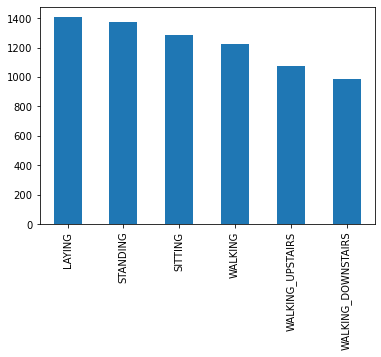

In [151]:
train['Activity'].value_counts().plot(kind='bar')
plt.show()

**Correlations**

In [152]:
correlation_matrix = train.corr()
correlation_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Index: 562 entries, tBodyAcc-mean()-X to subject
Columns: 562 entries, tBodyAcc-mean()-X to subject
dtypes: float64(562)
memory usage: 2.4+ MB


The correlation matrix is a 562x562 matrix (all numeric features correlated with all numeric features). Here are the first 10 rows and columns:

In [153]:
correlation_matrix.iloc[0:10, 0:10]

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X
tBodyAcc-mean()-X,1.000000,0.148061,-0.256952,0.000619,-0.021903,-0.044617,0.006290,-0.022754,-0.047558,0.044062
tBodyAcc-mean()-Y,0.148061,1.000000,-0.078769,-0.045160,-0.044920,-0.049746,-0.044180,-0.045049,-0.050402,-0.038108
tBodyAcc-mean()-Z,-0.256952,-0.078769,1.000000,-0.020217,-0.016641,-0.008410,-0.018747,-0.015203,-0.001988,-0.037197
tBodyAcc-std()-X,0.000619,-0.045160,-0.020217,1.000000,0.927461,0.851668,0.998632,0.920888,0.846392,0.980844
tBodyAcc-std()-Y,-0.021903,-0.044920,-0.016641,0.927461,1.000000,0.895510,0.922803,0.997347,0.894509,0.917366
tBodyAcc-std()-Z,-0.044617,-0.049746,-0.008410,0.851668,0.895510,1.000000,0.844469,0.891441,0.997418,0.853884
tBodyAcc-mad()-X,0.006290,-0.044180,-0.018747,0.998632,0.922803,0.844469,1.000000,0.916106,0.839267,0.973216
tBodyAcc-mad()-Y,-0.022754,-0.045049,-0.015203,0.920888,0.997347,0.891441,0.916106,1.000000,0.891178,0.910411
tBodyAcc-mad()-Z,-0.047558,-0.050402,-0.001988,0.846392,0.894509,0.997418,0.839267,0.891178,1.000000,0.847870
tBodyAcc-max()-X,0.044062,-0.038108,-0.037197,0.980844,0.917366,0.853884,0.973216,0.910411,0.847870,1.000000


We want to pick out the pairs with the highest correlation. We can do this using `unstack`, which turns all the values in the leftmost column (index column) into columns:

In [154]:
correlation_matrix.unstack().shape

(315844,)

In [155]:
correlation_matrix.unstack()[:5]

tBodyAcc-mean()-X  tBodyAcc-mean()-X    1.000000
                   tBodyAcc-mean()-Y    0.148061
                   tBodyAcc-mean()-Z   -0.256952
                   tBodyAcc-std()-X     0.000619
                   tBodyAcc-std()-Y    -0.021903
dtype: float64

Here are the 15 largest and smallest values:

In [156]:
correlation_matrix.unstack().drop_duplicates().sort_values()[:15]

tGravityAcc-arCoeff()-Z,1  tGravityAcc-arCoeff()-Z,2   -0.995297
tGravityAcc-mean()-Z       angle(Z,gravityMean)        -0.995070
tGravityAcc-arCoeff()-Z,2  tGravityAcc-arCoeff()-Z,3   -0.994684
tGravityAcc-arCoeff()-Z,3  tGravityAcc-arCoeff()-Z,4   -0.994256
tGravityAcc-mean()-Y       angle(Y,gravityMean)        -0.993502
tGravityAcc-max()-Z        angle(Z,gravityMean)        -0.992869
tGravityAcc-arCoeff()-Y,1  tGravityAcc-arCoeff()-Y,2   -0.991898
tGravityAcc-min()-Z        angle(Z,gravityMean)        -0.990991
tGravityAcc-max()-Y        angle(Y,gravityMean)        -0.990841
tGravityAcc-min()-Y        angle(Y,gravityMean)        -0.990047
tGravityAcc-arCoeff()-X,3  tGravityAcc-arCoeff()-X,4   -0.989856
tGravityAcc-arCoeff()-X,1  tGravityAcc-arCoeff()-X,2   -0.989752
tGravityAcc-arCoeff()-Y,2  tGravityAcc-arCoeff()-Y,3   -0.989747
tGravityAcc-energy()-X     angle(X,gravityMean)        -0.989607
tGravityAcc-arCoeff()-X,2  tGravityAcc-arCoeff()-X,3   -0.989342
dtype: float64

In [157]:
correlation_matrix.unstack().drop_duplicates().sort_values()[-15:]

fBodyAcc-bandsEnergy()-1,16  fBodyAcc-bandsEnergy()-1,24       0.998973
tBodyAcc-sma()               tBodyAccMag-mean()                0.999111
tBodyGyro-sma()              tBodyGyroMag-mean()               0.999234
tBodyGyro-energy()-Y         fBodyGyro-energy()-Y              0.999242
tBodyAcc-energy()-X          fBodyAcc-bandsEnergy()-1,24       0.999507
fBodyGyro-energy()-Z         fBodyGyro-bandsEnergy()-1,24.2    0.999523
tBodyAcc-energy()-X          fBodyAcc-energy()-X               0.999611
tBodyAccJerk-sma()           tBodyAccJerkMag-mean()            0.999656
fBodyAcc-energy()-Y          fBodyAcc-bandsEnergy()-1,24.1     0.999661
fBodyGyro-energy()-X         fBodyGyro-bandsEnergy()-1,24      0.999767
fBodyAcc-energy()-X          fBodyAcc-bandsEnergy()-1,24       0.999878
tBodyAccJerk-energy()-X      fBodyAccJerk-energy()-X           0.999999
tBodyAccJerk-energy()-Y      fBodyAccJerk-energy()-Y           1.000000
tBodyAccJerk-energy()-Z      fBodyAccJerk-energy()-Z           1

As expected, there's a lot of highly correlated features..

> **Your turn!** Try to remove one from each pair of very correlated features from the dataset before constructing models.

## Prepare the data for ML

In [158]:
X_train = train.drop('Activity', axis=1)
y_train = train['Activity']

X_test = test.drop('Activity', axis=1)
y_test = test['Activity']

## ML model

In [159]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

What's the accuracy?

In [160]:
y_pred = rf.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9267051238547676

Is this a good result? To answer that we can use the tools we learned about in Module 1 of the course.

## Evaluate the result

**Confusion matrix**

In [161]:
from utils import plot_confusion_matrix, plot_confusion_matrix_with_colorbar

In [162]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

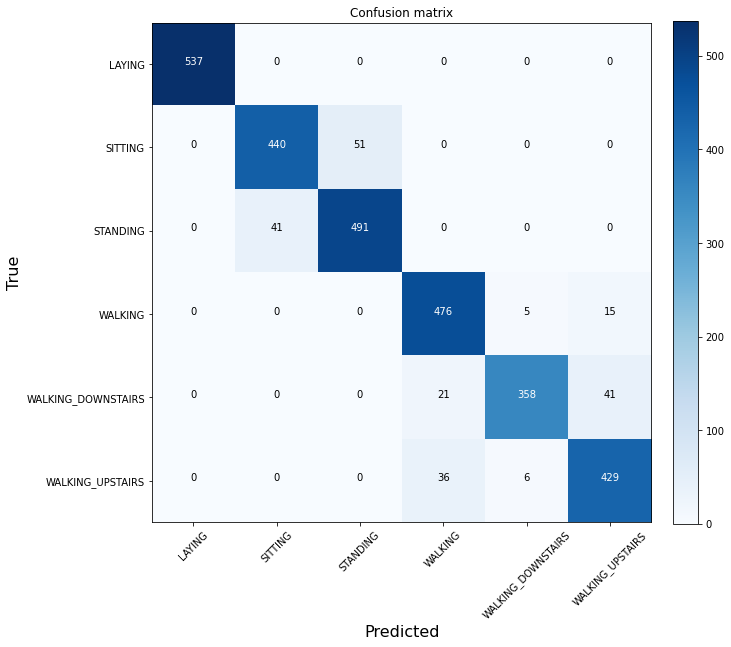

In [163]:
plot_confusion_matrix_with_colorbar(cm, classes=np.unique(y_test), figsize=(10,10))

**Feature importance**

In [164]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(10): 
    print(f'{X_test.columns[indices[f]]}: {np.round(importances[indices[f]],2)}')

tGravityAcc-mean()-X: 0.03
tGravityAcc-max()-X: 0.03
tGravityAcc-max()-Y: 0.03
tGravityAcc-min()-X: 0.03
angle(Y,gravityMean): 0.03
tGravityAcc-min()-Y: 0.03
tGravityAcc-energy()-X: 0.02
tGravityAcc-mean()-Y: 0.02
angle(X,gravityMean): 0.02
tGravityAcc-energy()-Y: 0.02


In [ ]:
# Warning! This takes quite some time since there's a large number of columns to shuffle...
perm = PermutationImportance(rf, random_state=42)
perm.fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

If you don't want to wait for the above cell to complete, here's the result:

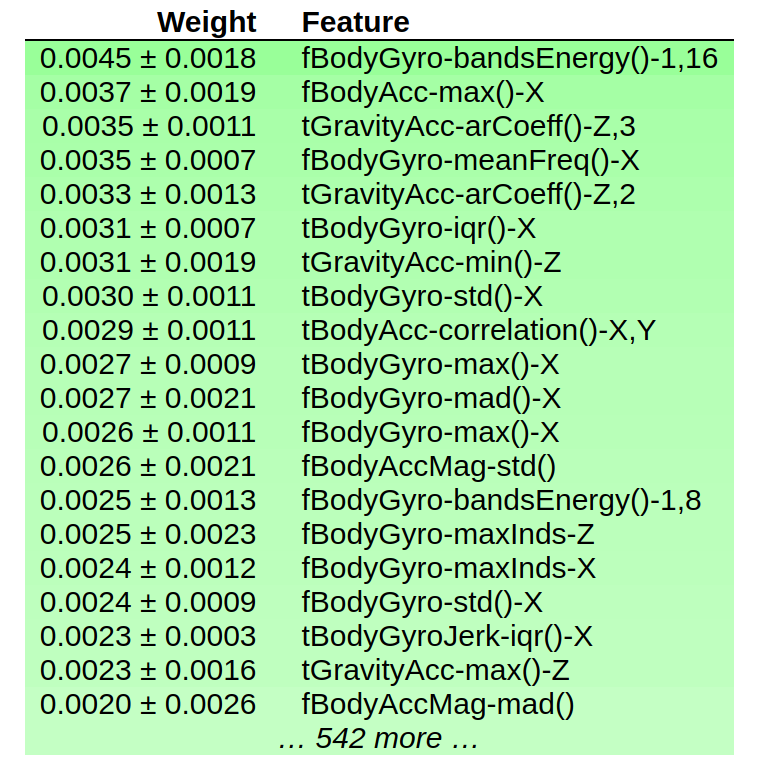

In [165]:
IPython.display.Image("assets/pi_activity.png", width='40%')

> **Your turn!** Try to improve the model by e.g. feature engineering, hyperparameter optimization and by selecting different models. 

>> Hint: using logistic regression one can reach 96% accuracy on the test set, outperforming the above random forest. Perhaps a `sklearn.ensemble.VotingClassifier` consisiting of some tree-based models and logistic regression could do even better?

Can you beat the following?

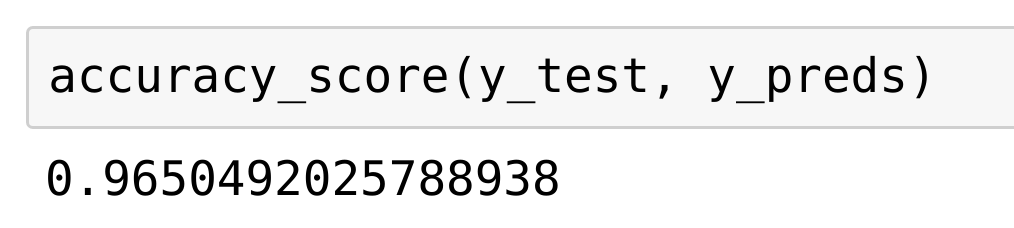

In [166]:
IPython.display.Image("assets/activity_result.png", width='40%')

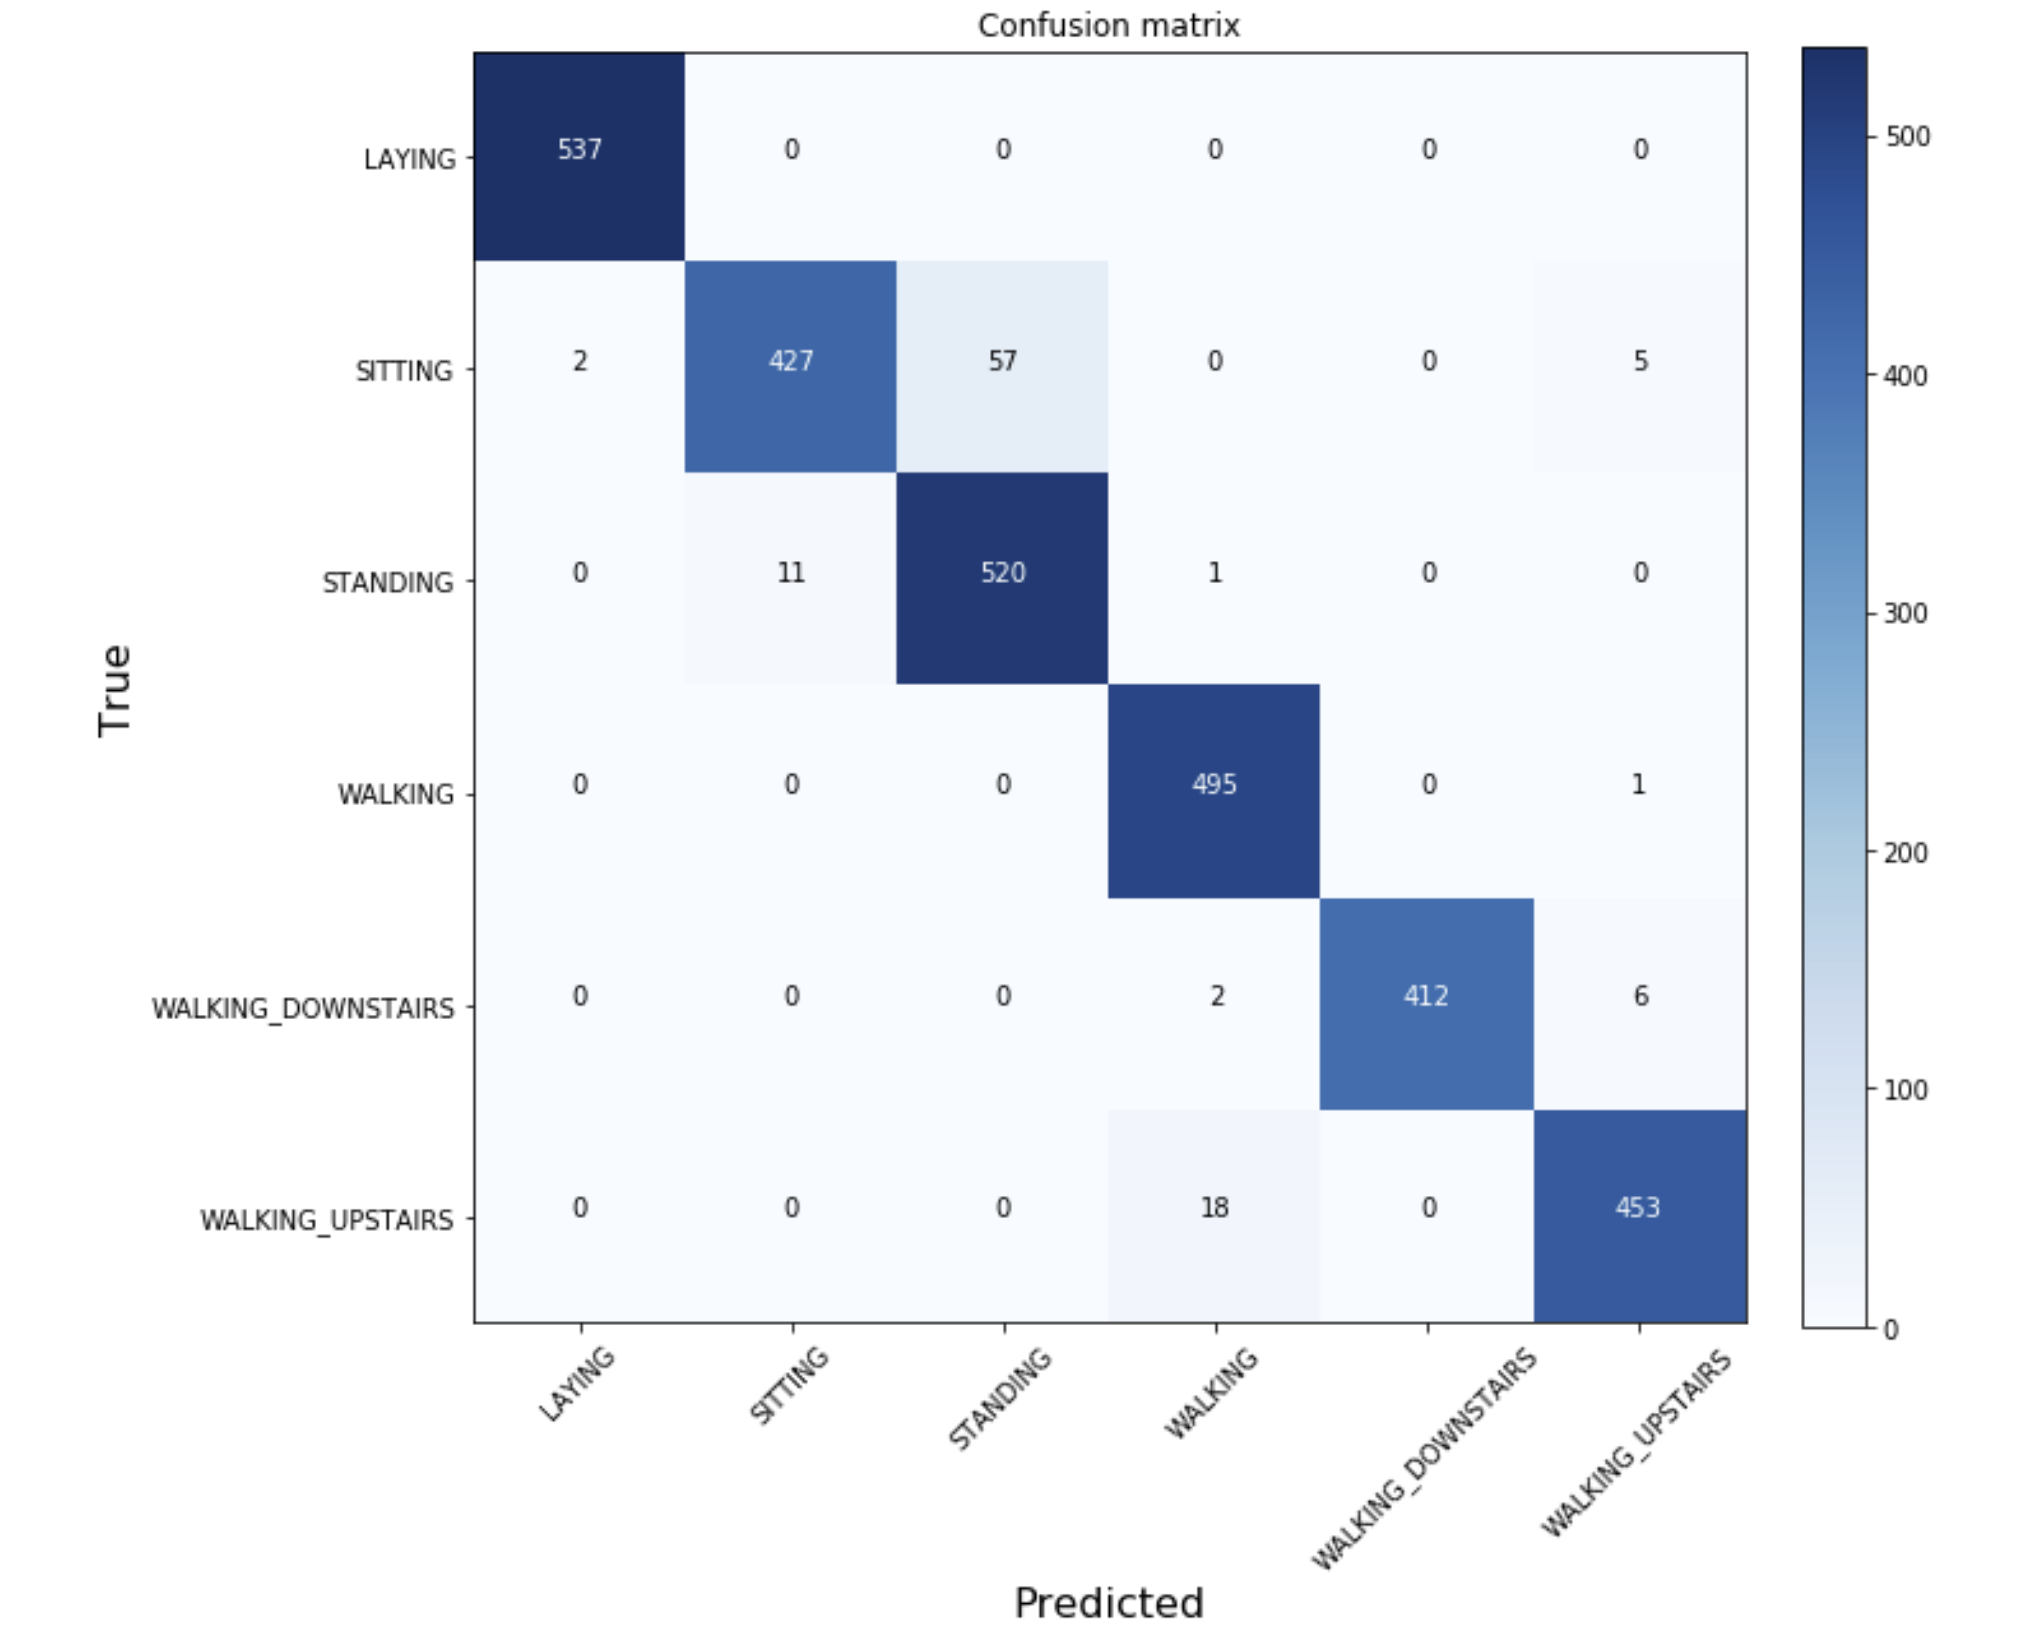

In [167]:
IPython.display.Image("assets/activity_cm.png", width='80%')